In [1]:
%run "RBM_Classification.ipynb"

class DBN_Classification(RBM_Classification):
    # n_k is the number of classes, n_d is the # of dots representing one class
    def __init__(self, n_x, layers, n_k=10, n_d=1, k=1, mean_field=True):
        if len(layers) == 1:
            top_rbm_x = n_x
            lower_dbn = None
        else:
            top_rbm_x = layers[-2][0]
            lower_dbn = DBN(n_x, layers[:-1], k=k, mean_field=mean_field)
        
        if layers[-1][1] is not None:
            top_rbm = RBM_Classification.load_model(layers[-1][1])
            if top_rbm.n_x != top_rbm_x or top_rbm.n_k != n_k or top_rbm.n_h != layers[-1][0]:
                raise ValueError("Incorrect input model for the top classification layer") 
        else:
            top_rbm = RBM_Classification(top_rbm_x, layers[-1][0], n_k, n_d, k=k)

        self.mean_field = mean_field
        self.n_layer = len(layers)
        self.top_rbm = top_rbm
        self.lower_dbn = lower_dbn
     
        if lower_dbn:
            if top_rbm.training_done and not lower_dbn.training_done:
                     raise ValueError("Top layer is trained while lower layer is not.")            
            self.training_done = top_rbm.training_done and lower_dbn.training_done
        else:
            self.training_done = top_rbm.training_done

        return
        
    # this is the API for app to use
    def train(self, X, Label, epochs=1, batch_size=10, learning=0.01, save_file=None):
        if self.training_done: return
        
        save_file += ".dbn_classify.layer" + str(self.n_layer)
        lower_dbn = self.lower_dbn
        if lower_dbn is not None:
            if not lower_dbn.training_done:
                self.lower_dbn.train_model(X, epochs, batch_size, learning, save_file)
                self.lower_dbn.training_done = True
        
            Hp, Hs = self.lower_dbn.forward(X)
            if not self.mean_field:
                X = []; sampling = 5
                for j in range(sampling):
                    Vs = np.random.binomial(1, Hp, size=Hp.shape)
                    X.append(Vs)
                X = np.asarray(X).reshape(-1, Hp.shape[1])
                Label = np.asarray(list(Label)*sampling)
            else:
                X = Hp
            
        # train the top RBM
        if self.top_rbm.training_done: return
        
        save_file += "-"+str(self.n_layer)
        X = self.top_rbm.convert_input(X, Label)
        self.top_rbm.train_model(X, epochs, batch_size, learning, save_file)
        self.training_done = True
        return
        
    def classify(self, x):
        x = x.reshape(1,-1)
        if self.lower_dbn is not None:
            x, hs = self.lower_dbn.forward(x)

        vp, pred = self.top_rbm.classify(x)
        
        vp = vp.reshape(1,-1)
        if self.lower_dbn is not None:
            vp, vs = self.lower_dbn.backward(vp)

        return vp[0], pred
    
    def reconstruct_from_label(self, label, k_gibbs, init_w, w):
        lower_dbn = self.lower_dbn
        if lower_dbn:
            n_x = lower_dbn.rbms[0].n_v
            np.random.seed(111)
            #hp = np.random.binomial(1, 0.1, n_x)  #mnist_dbn.generate(k_gibbs=50, init_w=2, w=1.4)
            #hp = np.full(n_x, 0.1)                #mnist_dbn.generate(k_gibbs=50, init_w=3.5, w=3.5)
            hp = np.full(n_x, 0.15)                #mnist_dbn.generate(k_gibbs=6, init_w=8, w=8)
            hp, hs = lower_dbn.forward(hp.reshape(1,-1)); hp=hp[0]
            vp = self.top_rbm.reconstruct(hp, label, k_gibbs, init_w, w)
        else:
            vp = self.top_rbm.reconstruct_from_label(label, k_gibbs, init_w, w)
        
        vp = vp.reshape(1,-1)
        if self.lower_dbn is not None:
            vp, vs = self.lower_dbn.backward(vp)

        return vp[0]
    
    def show_features(self, shapes, title, count=-1):
      
        lower_rbm = self.lower_dbn.show_features(shapes[:-1], title, count)

        top_rbm = self.top_rbm; n_x = top_rbm.n_x; n_k = top_rbm.n_k; n_d = top_rbm.n_d
        W = top_rbm.W; n_h = W.shape[0]
        minw = np.amin(W)
        Wx = W[:, :n_x]
        Wkd = W[:, n_x:]
        shape = shapes[-1]
        #padding = np.full(shape[1] - n_kd, minw).reshape(1,-1).repeat(n_h, axis=0)
        #Wk = np.append(Wkd, padding, axis=1)
        #assert Wk.shape == (n_h, shape[1])
        
        W = np.dot(Wx, lower_rbm.W)
        #W = np.append(W, Wk, axis=1)
        #shape = (shape[0]+1, shape[1])
        assert W.shape == (n_h, shape[0]*shape[1])
        
        rbm = RBM(W.shape[1], W.shape[0], W=W)   
        rbm.show_features(shape, title + " learned features in layer %d" % (self.n_layer), count)

        rbm = RBM(Wkd.shape[1], Wkd.shape[0], W=Wkd)   
        shape = (n_k, n_d)
        rbm.show_features(shape, title + " label features in layer %d" % (self.n_layer), count)
        return



In [2]:
# testing of the RBM Classification_Generation code above

%run "mnist.ipynb"
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Grid
import math

class MNIST_DBN_CLASSIFY(MNIST_RBM_CLASSIFY):
    def __init__(self, n_x, layers, n_k=10, n_d=1, mean_field=True, folder="../convolution-network"):
        self.train_input = MnistInput("train", folder)
        self.test_input = MnistInput("test", folder)
        self.net = DBN_Classification(n_x, layers, n_k, n_d, mean_field=mean_field)
        return


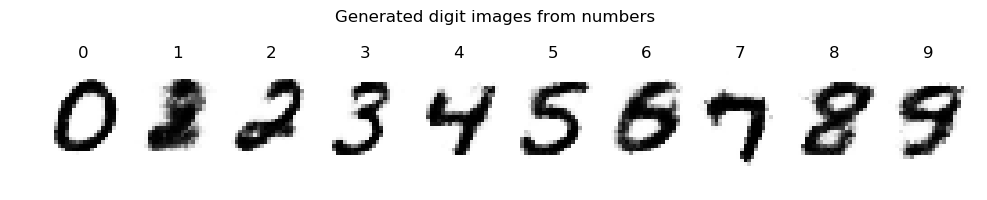

In [3]:
%run "DBN.ipynb"
%run "RBM_Classification.ipynb"

mnist_dbn = None
if __name__ == "__main__" and '__file__' not in globals():
    np.seterr(all='raise')
    plt.close('all')

    v = (28,28); h1 = (20,25); h2 = (20,25); h3 = (2000,1)
    
    layers = [
        (mult(h1), "trained_models/mnist.dbn_classify.layer3-1.epochs100.784x500"), # (dimension, "model_file") of hidden layer 1
#        (mult(h1), None),  # (dimension, "model_file") of 2nd layer
        (mult(h2), "trained_models/mnist.dbn_classify.layer3-2.epochs100.500x500"), # (dimension, "model_file") of hidden layer 2
#        (mult(h2), None),  # (dimension, "model_file") of 2nd layer
        (mult(h3), "trained_models/mnist.dbn_classify.layer3-3.epochs100.(500+10x10)x2000")  # (dimension, "model_file") of top layer
#        (mult(h3), None)  # (dimension, "model_file") of top layer
    ]

    ## for model: "trained_models/mnist.dbn_classify.layer3-3.epochs100.(500+10)x2000")  # (dimension, "model_file") of top layer
    ## mnist_dbn.generate(k_gibbs=60, init_w=3, w=3)  #hp = np.full(n_x, 0.15)

    mnist_dbn = MNIST_DBN_CLASSIFY(mult(v), layers, n_d=10, mean_field=True, folder="../convolution-network")
    mnist_dbn.train(train_size=-1, n_epoch=100, batch_size=10)
    #mnist_dbn.net.show_features([v, v, v], "MNIST %d-layer DBN_Classification" %(len(layers)), 56)
    mnist_dbn.generate(k_gibbs=300, init_w=1.2, w=1.1)  #hp = np.full(n_x, 0.15)
    #mnist_dbn.classify()
    



Classification accuracy: 0.9239


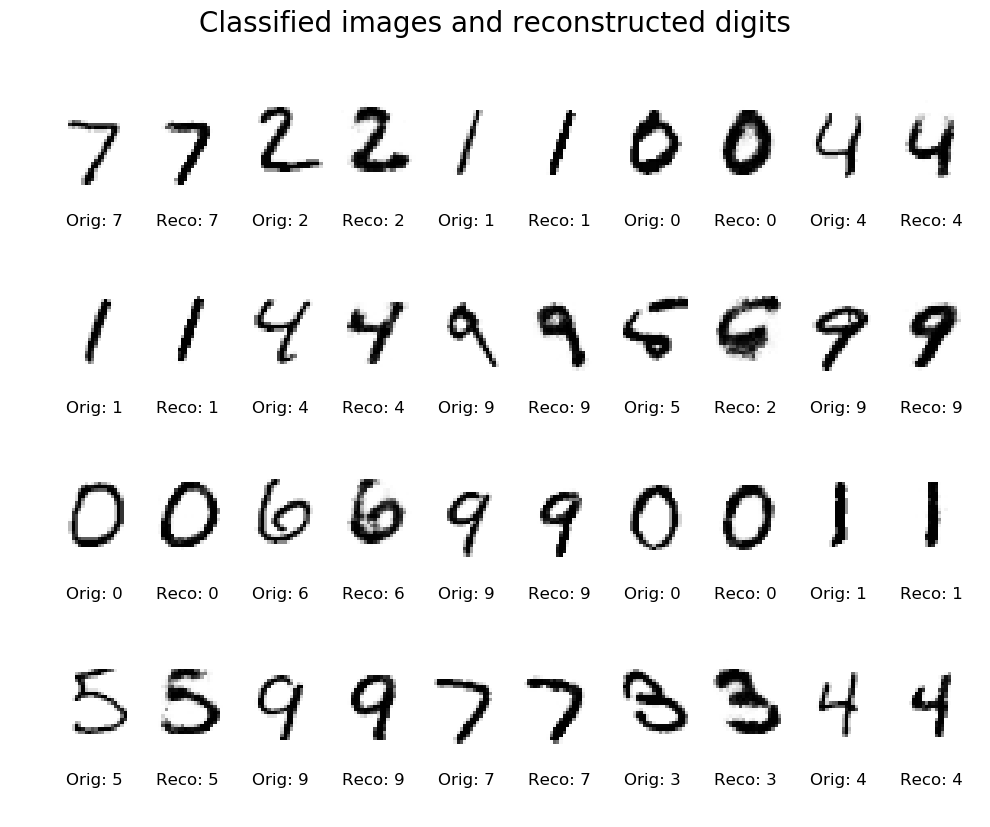

In [4]:
%run "DBN.ipynb"
%run "RBM_Classification.ipynb"

mnist_dbn = None
if __name__ == "__main__" and '__file__' not in globals():
    np.seterr(all='raise')
    plt.close('all')

    v = (28,28); h1 = (20,25); h2 = (20,25); h3 = (561,1)
    
    layers = [
        (mult(h1), "trained_models/mnist.dbn_classify.layer3-1.epochs100.784x500"), # (dimension, "model_file") of hidden layer 1
#        (mult(h1), None),  # (dimension, "model_file") of 2nd layer
        (mult(h2), "trained_models/mnist.dbn_classify.layer3-2.epochs100.500x500"), # (dimension, "model_file") of hidden layer 2
#        (mult(h2), None),  # (dimension, "model_file") of 2nd layer
        (mult(h3), "trained_models/mnist.dbn_classify.layer3-3.epochs100.(500+10)x561")  # (dimension, "model_file") of top layer
#        (mult(h3), None)  # (dimension, "model_file") of top layer
    ]

    mnist_dbn = MNIST_DBN_CLASSIFY(mult(v), layers, mean_field=True, folder="../convolution-network")
    mnist_dbn.train(train_size=-1, n_epoch=100, batch_size=10)
    #mnist_dbn.net.show_features([v, v, v], "MNIST %d-layer DBN_Classification" %(len(layers)), 56)
    #mnist_dbn.generate(k_gibbs=60, init_w=8, w=8)  #hp = np.full(n_x, 0.15)
    mnist_dbn.classify()
